In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import os
import warnings
warnings.filterwarnings("ignore")

In [17]:
df = pd.read_excel('Final_data1.xlsx')

## Clustering K-Means

In [25]:
## Cluster's the data creates skill matrix
grp = df.groupby(['Operator Name','Operation Name '])
grp_df = grp.mean()
sam = grp_df['SAM'].values
cycles = grp_df.iloc[:,1:].values
cycl_nrm = []
for i,rw in enumerate(cycles):
    cycl_nrm.append(rw)
cycles = np.array(cycl_nrm)
df_cmmn = grp.first()
Opn_Grade = pd.get_dummies(df_cmmn['Opn Grade'],prefix='Opn Grade')
Machine_Type = pd.get_dummies(df_cmmn['Machine Type'],prefix='Machine Type')
fnl_data = np.hstack([Machine_Type,Opn_Grade,cycles])

kmns = KMeans(n_clusters=25,n_init=100,max_iter=500,tol=1e-3,n_jobs=-1, random_state=5).fit(fnl_data)
df_clstr = pd.concat([pd.DataFrame(fnl_data[:,-30:]),pd.DataFrame(kmns.labels_,columns=['cluster'])],axis=1)
clstr_mn = df_clstr.groupby('cluster').mean().mean(axis=1)
clstr_mn_dct = dict(zip(clstr_mn.index,clstr_mn.values))
df_clstr['cluster'].replace(clstr_mn_dct,inplace=True)
sk_mt=[]
for i,rw in enumerate(df_clstr['cluster']):
    sk_mt.append(rw)
df_clstr['skill_value'] = sk_mt
grp_df['skill_value'] = sk_mt
grp_df['sam']=grp_df['SAM']*60
sam_oprtn={}
for i,n in enumerate(df['Operation Name ']):
    sam_oprtn[n]=df['SAM'][i]
oprtr,oprtn = [],[]
for r,n in grp_df.index.values:oprtr.append(r);oprtn.append(n)
skill_matrix = pd.DataFrame(index=['SAM']+list(df['Operator Name'].unique()),columns=df['Operation Name '].unique())
for i,c in enumerate(grp_df.index.values):
    r,n=c
    skill_matrix.loc[r,n]= grp_df['skill_value'][i]
    skill_matrix.loc['SAM',n] = sam_oprtn[n]*60
    
r_id=[None]
tmp=df.groupby('Operator Name').first()['Operator ID']
for r in skill_matrix.index[1:]:
    r_id.append(tmp.loc[r])
skill_matrix.insert(0,'Operator ID',r_id)
m_type=[None]
tmp=df.groupby('Operation Name ').first()['Machine Type']
for n in skill_matrix.columns[1:]:
    m_type.append(tmp.loc[n])
tmp=pd.DataFrame(np.array([m_type]),columns=skill_matrix.columns)
l=list(pd.concat([tmp,skill_matrix]).index)
l[0]='Machine Type'
skill_matrix=pd.concat([tmp,skill_matrix])
skill_matrix.index=l
skill_matrix_prcntg = pd.concat([skill_matrix.iloc[:2,:],(skill_matrix.loc['SAM']/skill_matrix.iloc[2:,:])*100])
skill_matrix_prcntg['Operator ID']=skill_matrix['Operator ID']
skill_matrix.to_csv('skill_matrix.csv',na_rep='N.A')
skill_matrix_prcntg.to_csv('skill_matrix_prcntg.csv',na_rep='N.A')

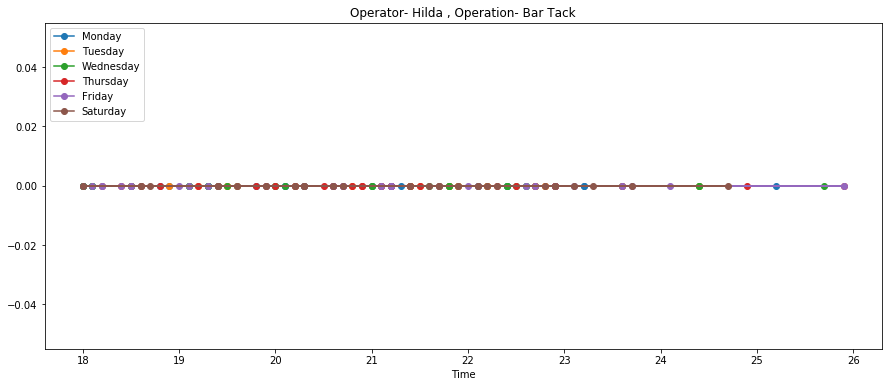

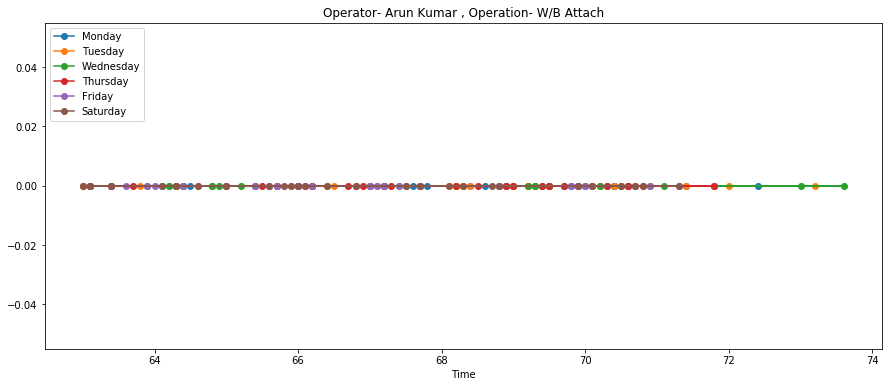

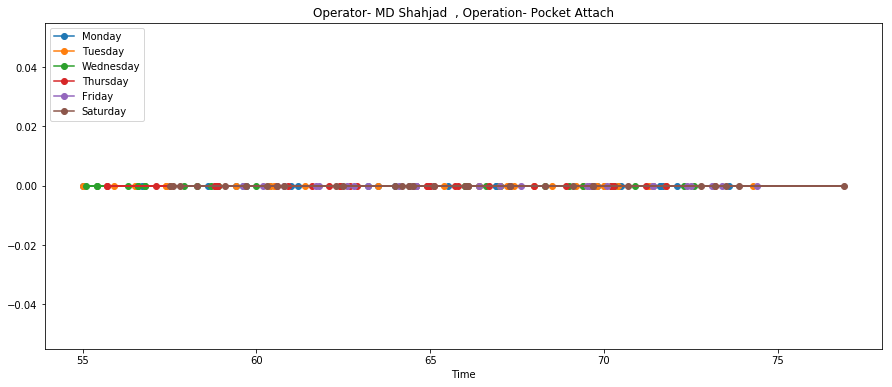

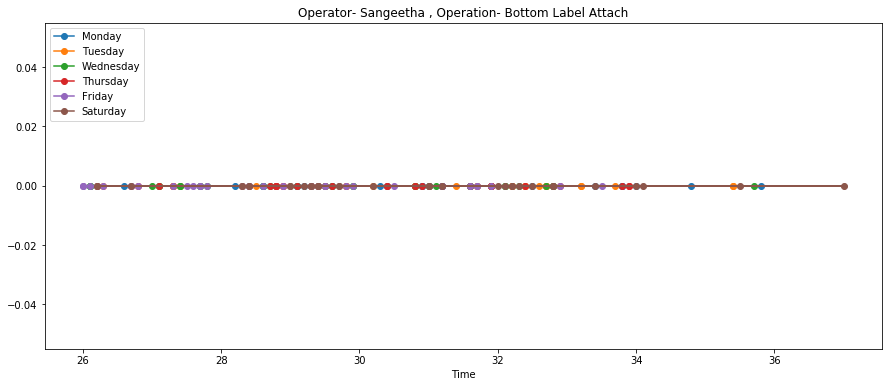

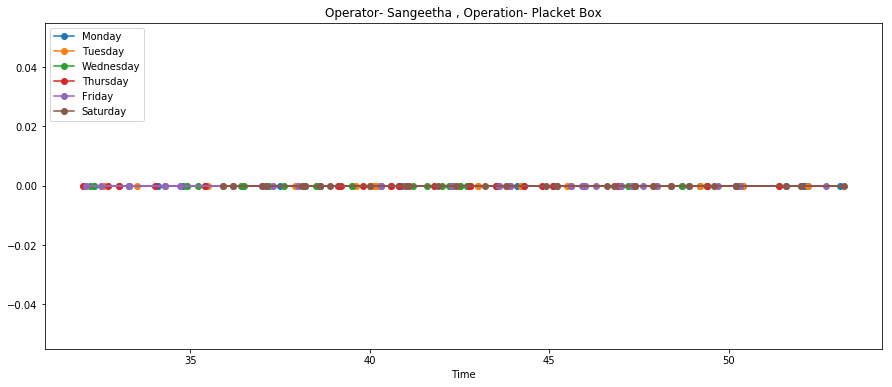

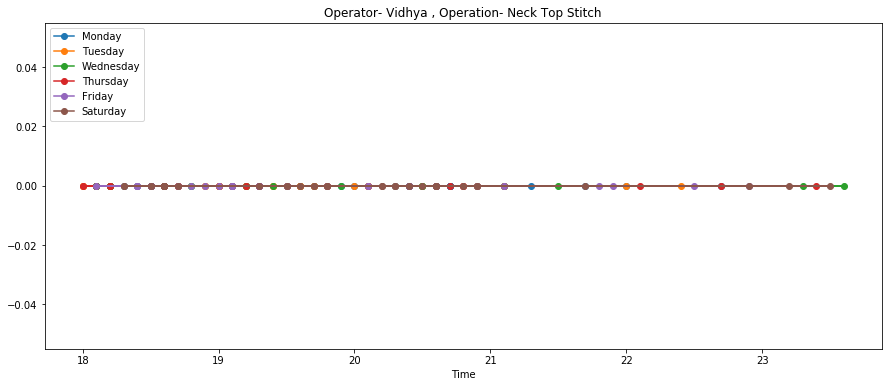

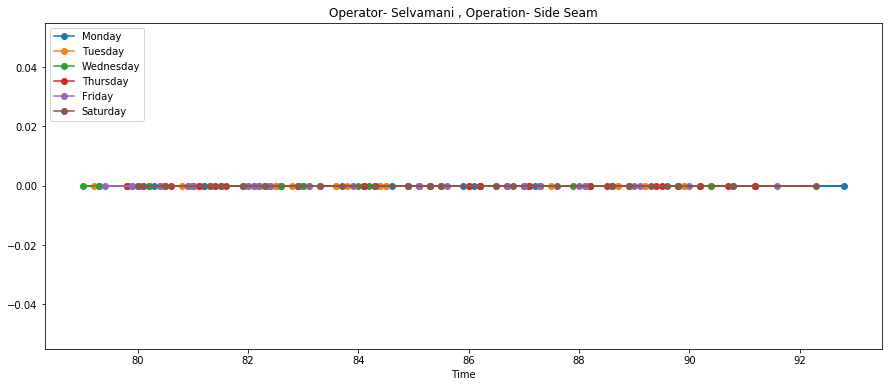

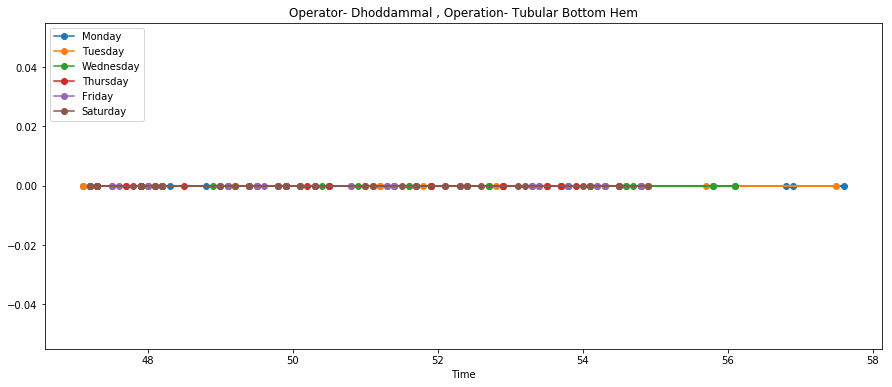

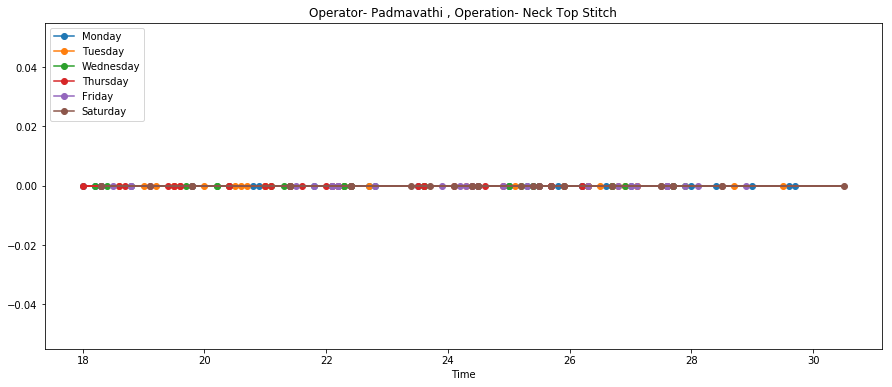

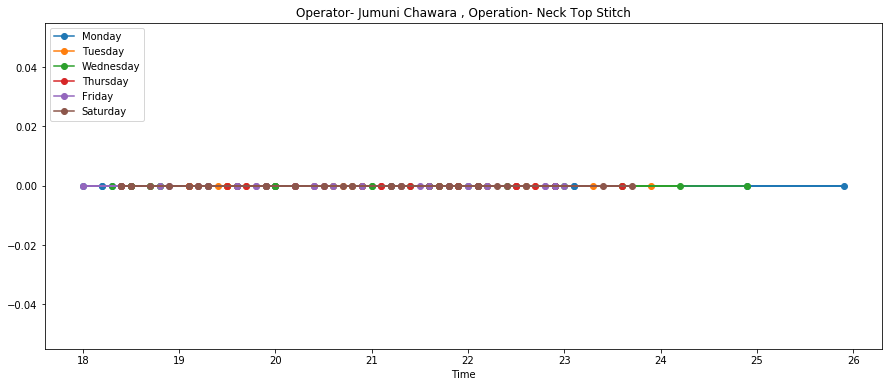

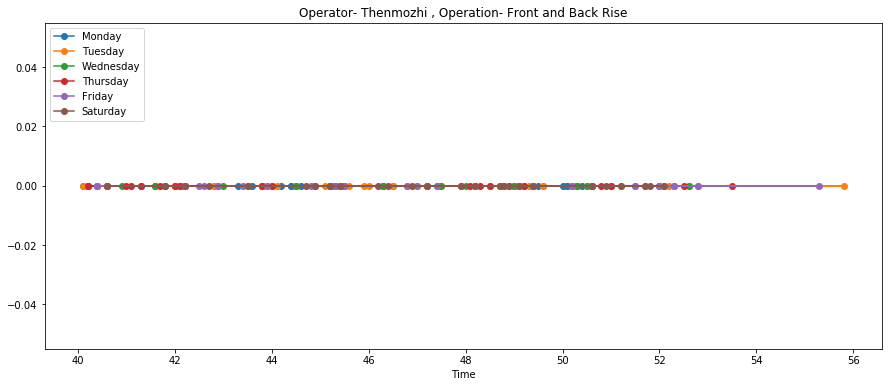

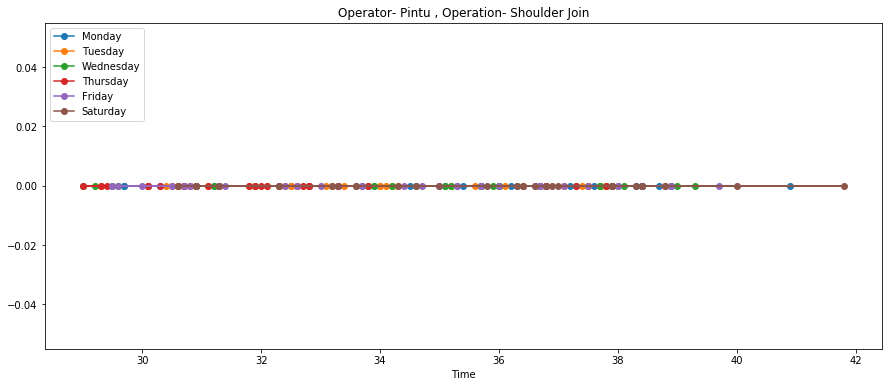

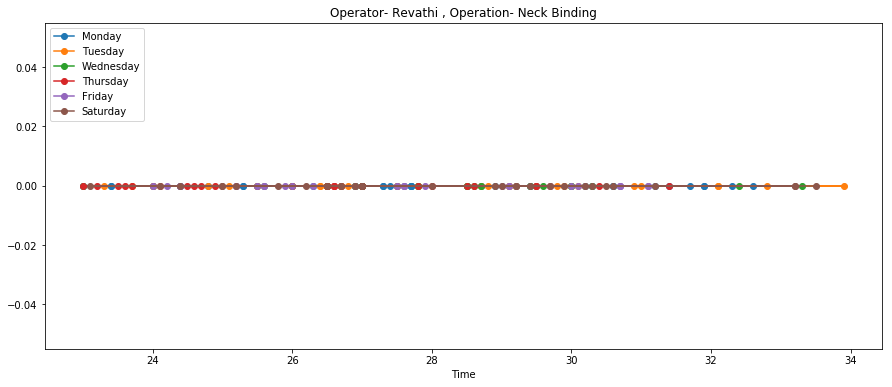

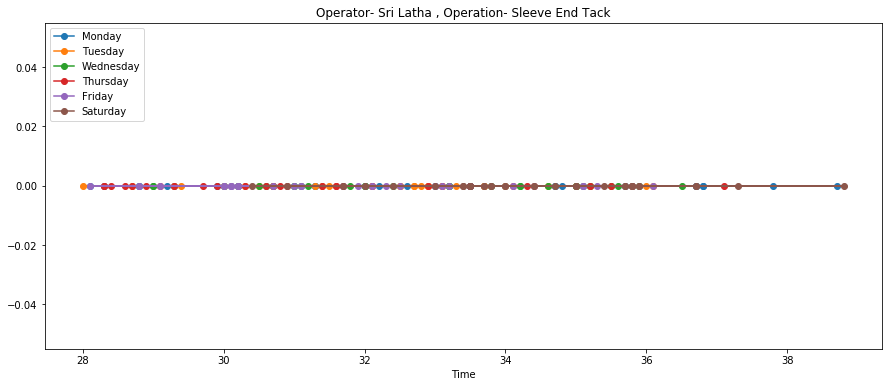

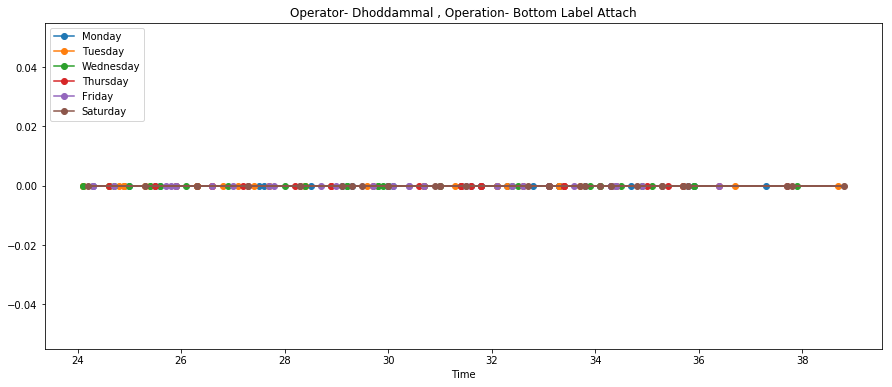

In [24]:
path='plots/'
if not os.path.exists(path):os.makedirs(path)
df = pd.read_excel('Final_data1.xlsx')
df.drop(['Operator ID'],axis=1,inplace=True)
days = list(df['Day of the Week'].unique())#[:-1]
x=list(g.indices.keys())
for _ in range(15):
    r,n=x[np.random.randint(len(x))]
    smpl = df[(df['Operator Name']==r) & (df['Operation Name ']==n)].iloc[:,-30:]
    fig = plt.figure(figsize=(15,6))
    for i,day in enumerate(days):
        plt.plot(smpl.iloc[i],[0 for i in range(smpl.shape[1])],label=day,marker='o');

    plt.xlabel('Time')
    plt.title("Operator- %s , Operation- %s"%(r,n));
    plt.legend(loc=2);
    fig.savefig(path+r'%s_%s.jpg'%(r.replace('/',''),n.replace('/','')))